In [1]:
import random
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [3]:
#path_to_dataset = './fake_news_dataset.csv'
#path_to_dataset = '/Users/tithighosh/Library/Application Support/AirDroid/Downloads/Fake news_/datasets/fake_news_dataset.csv'
path_to_dataset = 'https://drive.google.com/file/d/1IOY0q_7Mnqb6_BmoQP0BRdOlmtqEUZd9/view?usp=sharing

In [4]:
data = pd.read_csv(path_to_dataset, index_col=0)

In [5]:
data.head()

,date,day,flag,link,month,place,publisher,year,Text
0,2018/03/29,29.0,0,http://timesofindia.indiatimes.com//city/nagpu...,3.0,nagpur,TOI,2018.0,NAGPUR: Villagers in Naxalite infested Gadchir...
1,2017/01/24,24.0,0,http://timesofindia.indiatimes.com//india/jk-g...,1.0,NaN,TOI,2017.0,NEW DELHI: The Jammu & Kashmir government has ...
2,2017/01/31,31.0,0,http://timesofindia.indiatimes.com//city/kolha...,1.0,kolhapur,TOI,2017.0,KOLHAPUR: Robbers continue to give sleepless n...
3,2018/03/26,26.0,0,http://timesofindia.indiatimes.com//city/hubba...,3.0,hubballi,TOI,2018.0,"HUBBALLI: An iconic building, which is propose..."
4,2017/02/20,20.0,0,http://timesofindia.indiatimes.com//city/mumba...,2.0,mumbai,TOI,2017.0,MUMBAI: MNS chief said that the would lead...


In [6]:
data.groupby('flag').count()

,date,day,link,month,place,publisher,year,Text
flag,,,,,,,,
0,209321,209320,209321,209320,145796,209321,209320,209321
1,805,805,805,805,617,805,805,805


## Removing Skewness

In [7]:
zero_indices = data[data['flag']==0].index

In [8]:
zero_indices_to_remove = random.sample(list(zero_indices), 208321)

In [9]:
len(set(zero_indices_to_remove))

208321

In [10]:
zero_indices_to_remove = dict(zip(zero_indices_to_remove, ['']*208321))

In [11]:
temp = pd.DataFrame(columns=data.columns)

In [12]:
for lab, row in data.iterrows():
     
    if lab not in zero_indices_to_remove:
        temp.loc[lab, :] = data.loc[lab, :]

In [13]:
temp.describe(include='all')

,date,day,flag,link,month,place,publisher,year,Text
count,1805,1805.0,1805,1805,1805.0,1331,1805,1805.0,1805
unique,330,31.0,2,1805,10.0,175,1,2.0,1768
top,2018/03/30,3.0,0,http://timesofindia.indiatimes.com//life-style...,3.0,mumbai,TOI,2017.0,NEW DELHI: Police have busted a pan-India op...
freq,16,74.0,1000,1,380.0,127,1805,958.0,3


In [14]:
data = temp.copy()

In [15]:
data['flag'].value_counts()

0    1000
1     805
Name: flag, dtype: int64

<BarContainer object of 2 artists>

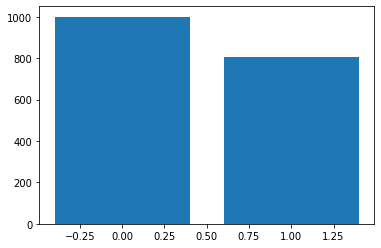

In [16]:
plt.bar((0,1), data['flag'].value_counts())

## Validating Data

In [17]:
data['day'].unique()

array([3.0, 27.0, 17.0, 30.0, 18.0, 12.0, 25.0, 19.0, 4.0, 9.0, 26.0,
       10.0, 16.0, 31.0, 1.0, 22.0, 13.0, 29.0, 14.0, 20.0, 6.0, 28.0,
       23.0, 2.0, 21.0, 24.0, 5.0, 8.0, 15.0, 7.0, 11.0], dtype=object)

In [18]:
data['month'].unique()

array([2.0, 1.0, 4.0, 7.0, 9.0, 6.0, 3.0, 5.0, 10.0, 8.0], dtype=object)

In [19]:
data['year'].unique()

array([2017.0, 2018.0], dtype=object)

## Missing Values

In [20]:
data.isnull().sum()

date           0
day            0
flag           0
link           0
month          0
place        474
publisher      0
year           0
Text           0
dtype: int64

In [21]:
data['place'].isnull().sum()/data.shape[0]

0.2626038781163435

'place' has 30% missing values. So this attribute is dropped.

In [22]:
data.drop('place', axis=1, inplace=True)

'day' and 'year' have 1 missing value. So these observations are dropped only.

In [23]:
data.dropna(axis=0, inplace=True)

In [24]:
data.isnull().sum()

date         0
day          0
flag         0
link         0
month        0
publisher    0
year         0
Text         0
dtype: int64

## Rearranging Columns

In [25]:
data.columns

Index(['date', 'day', 'flag', 'link', 'month', 'publisher', 'year', 'Text'], dtype='object')

In [26]:
arranged_data = data[['Text', 'date', 'day', 'link', 'month', 'publisher', 'year', 'flag']]

In [27]:
arranged_data.head()

,Text,date,day,link,month,publisher,year,flag
83,"Yesterday, a young man was murdered in broadli...",2017/02/03,3,http://timesofindia.indiatimes.com//city/nagpu...,2,TOI,2017,1
104,NEW DELHI: The has set up a for its soldie...,2017/01/27,27,http://timesofindia.indiatimes.com//india/army...,1,TOI,2017,1
601,BERHAMPUR: An anti-social allegedly involved i...,2017/02/17,17,http://timesofindia.indiatimes.com//city/cutta...,2,TOI,2017,0
884,PATNA: One Akash Kumar (19) allegedly committe...,2018/01/30,30,http://timesofindia.indiatimes.com//city/patna...,1,TOI,2018,1
1023,GREATER NOIDA: being taught in universities ...,2018/04/18,18,http://timesofindia.indiatimes.com//city/noida...,4,TOI,2018,0


## Feature Selection

### Day  

In [28]:
grp = arranged_data.groupby('day')['flag'].sum()

<BarContainer object of 31 artists>

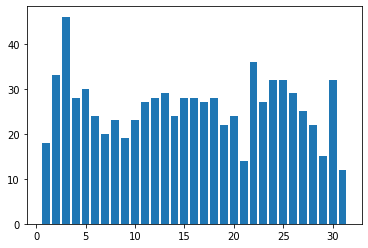

In [29]:
plt.bar(grp.index, grp.values)

### Month 

In [30]:
grp = arranged_data.groupby('month')['flag'].sum()

<BarContainer object of 10 artists>

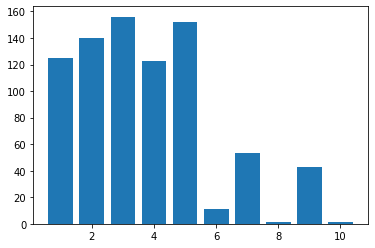

In [31]:
plt.bar(grp.index, grp.values)

In [32]:
data.drop('month', axis=1, inplace=True)

### Year, Publisher, date, day, link

In [33]:
data.drop(['year','publisher','date','day','link'], axis=1, inplace=True)

In [34]:
data.head()

,flag,Text
83,1,"Yesterday, a young man was murdered in broadli..."
104,1,NEW DELHI: The has set up a for its soldie...
601,0,BERHAMPUR: An anti-social allegedly involved i...
884,1,PATNA: One Akash Kumar (19) allegedly committe...
1023,0,GREATER NOIDA: being taught in universities ...


## X-y Split

In [35]:
X = data.iloc[:,1]
y = data.iloc[:,0]

In [36]:
X

83        Yesterday, a young man was murdered in broadli...
104       NEW DELHI: The   has set up a   for its soldie...
601       BERHAMPUR: An anti-social allegedly involved i...
884       PATNA: One Akash Kumar (19) allegedly committe...
1023      GREATER NOIDA:   being taught in universities ...
                                ...                        
209397    MUMBAI: The   was circulated at least 20 minut...
209459    NEW DELHI: A 35-year-old welder died when he f...
209555    MUMBAI: A day after a youth was   in a narrow ...
209762    Vadodara: His father made a name for himself i...
210051    NEW DELHI: India's economic growth is expected...
Name: Text, Length: 1805, dtype: object

## Removing Stopwords

In [37]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUM_RE = re.compile(' \d+ ')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
   
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = re.sub(NUM_RE, ' ', text)
    text = [e for e in text.split(' ') if e not in STOPWORDS and e!='']
    return text

In [38]:
X = [text_prepare(x) for x in X] 

In [39]:
y=list(y.values)

## Stemming

In [40]:
stemmer = nltk.stem.WordNetLemmatizer()

In [41]:
for i in range(len(X)):
    
    X[i] = [stemmer.lemmatize(e) for e in X[i]]
        

In [42]:
X = [' '.join(e) for e in X]

## Train-Test Split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

## TF-IDF

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [45]:
vector = CountVectorizer()
vector.fit(X)

CountVectorizer()

In [46]:
tf_vector = TfidfTransformer()

In [47]:
counts = vector.transform(X_train)
X_train = tf_vector.fit_transform(counts)

In [48]:
counts = vector.transform(X_test)
X_test = tf_vector.fit_transform(counts)

In [49]:
temp = X_train[:5]

In [50]:
X_test = X_test.toarray()

In [51]:
X_train = X_train.toarray()

# Naive-Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


model = MultinomialNB().fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

0.8116343490304709


## Saving the Model

In [57]:
#with open('Fake_News_NB_Model', 'wb') as f:
    #pickle.dump([model,vector,tf_vector], f)